# Edge Impulse - Spectral Analysis Block
Implementation_version >= 2
- by Marcelo Rovai @ Feb23

### Statistical features per axis/channel:
After filtering via a Butterworth IIR filter (if enabled), **the mean is subtracted from the signal.** Several statistical features (RMS, skewness, kurtosis) are calculated from the filtered signal after the mean has been removed. 
- RMS (from Normalized data)
- Skewness
- Kurtosis

### Spectral features per axis/channel:
The filtered signal is passed to the Spectral power section, which computes the FFT in order to compute the spectral features.
- Maximum value from FFT frames for each bin that was not filtered out
- The total number of features will change, depending on how you set the filter and FFT parameters.

https://docs.edgeimpulse.com/docs/edge-impulse-studio/processing-blocks/spectral-features

The Total Number of processed Featues per axis will be:
- RMS
- Skewness
- Curtosis
- 1/2 of FFT Lenght (no Filter)

For example, 
- for a FFT Lengh of 64 and filter NONE, the Total Processed Features per axis will be 35
- for a FFT Lengh of 64 and filter LOW, the Total Processed Features per axis will be lower than 35 depending on Filter Cut-off frequency (LOW: skip everything > cutoff; HIGH: skip everything < cutoff)

## Statistical features

In [53]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import math
from scipy.stats import skew, kurtosis
from scipy import signal
from sklearn import preprocessing

Let's have a datasample of one accelerometer axix (2 seconds window; Sample frequency 62.5Hz)

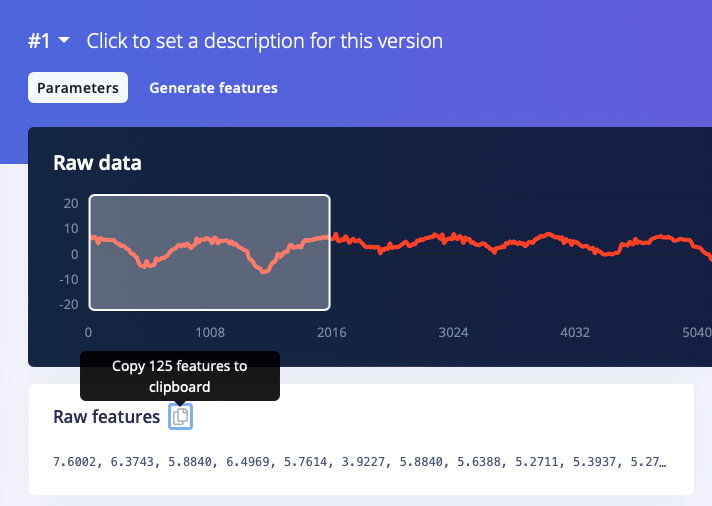

In [23]:
data=[7.6002, 6.3743, 5.8840, 6.4969, 5.7614, 3.9227, 5.8840, 5.6388, 5.2711, 5.3937, 5.2711, 5.2711, 5.1485, 5.1485, 4.4130, 3.8001, 3.5549, 2.8194, 2.9420, 2.3291, 1.7162, 1.2258, -0.1226, -0.2452, -1.1032, -1.8387, -3.8001, -4.9033, -5.0259, -5.3937, -3.0646, -4.6582, -5.0259, -4.6582, -4.6582, -2.0839, -2.6968, -2.4517, -1.8387, -1.8387, -1.2258, -0.7355, 0.3677, 1.1032, 1.5936, 1.8387, 2.8194, 3.3097, 2.6968, 3.4323, 2.9420, 3.8001, 3.0646, 2.0839, 2.9420, 3.3097, 5.7614, 4.2904, 5.2711, 5.3937, 5.2711, 6.0066, 5.5162, 5.2711, 4.0452, 6.0066, 5.8840, 3.9227, 4.9033, 4.7807, 4.9033, 5.0259, 4.7807, 3.9227, 4.6582, 3.4323, 3.8001, 2.9420, 2.3291, 2.0839, 1.4710, 1.1032, 0.7355, -1.9613, -2.5742, -3.3097, -4.7807, -5.3937, -5.7614, -6.2517, -7.4776, -7.3550, -7.1098, -6.8647, -5.3937, -3.9227, -3.5549, -2.4517, -0.3677, -1.4710, -0.7355, 0.1226, 0.4903, 0.7355, 2.9420, 3.1872, 2.2065, 2.4517, 2.5742, 2.6968, 2.4517, 4.1678, 5.0259, 5.0259, 5.0259, 5.1485, 5.2711, 5.6388, 5.7614, 5.8840, 5.8840, 6.2517, 6.2517, 6.1292, 6.4969]

In [24]:
N = len(data)
N

125

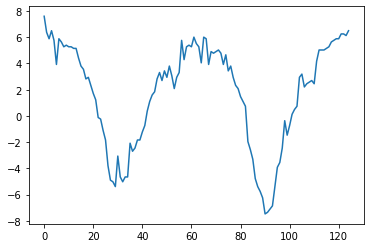

In [25]:
x = list(range(0, N))
sns.lineplot(x, data);

###Subtrating the mean from data (Used by EI)
Subtracting the mean from a set of data is a common data pre-processing step in statistics and machine learning. The purpose of subtracting the mean from data is to center the data around zero. This is important because it can reveal patterns and relationships that might be hidden if the data is not centered.

Here are some specific reasons why subtracting the mean can be useful:

- It simplifies analysis: By centering the data, the mean becomes zero, which can make some calculations simpler and easier to interpret.
- It removes bias: If the data has a bias, subtracting the mean can remove that bias and allow for more accurate analysis.
- It can reveal patterns: Centering the data can help reveal patterns that might be hidden if the data is not centered. For example, if you are analyzing a time series dataset, centering the data can help you identify trends over time.
- It can improve performance: In some machine learning algorithms, centering the data can improve performance by reducing the influence of outliers and making the data more easily comparable.
Overall, subtracting the mean is a simple but powerful technique that can be used to improve the analysis and interpretation of data.

In [26]:
dtmean = sum(data)/len(data)
dtmean

1.7151832000000005

In [27]:
stand_data = data.copy()
stand_data = [(x - dtmean) for x in stand_data]

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


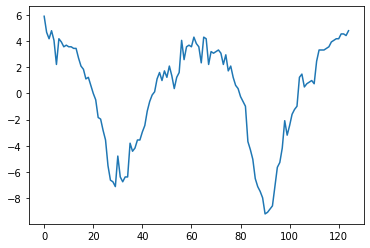

In [28]:
sns.lineplot(x, stand_data);

### Normalize data [-1,1] (Not used by EI)

In [29]:
dtmin, dtmax = min(data), max(data)
dtmin, dtmax

(-7.4776, 7.6002)

In [30]:
norm_data = data.copy()
norm_data = [((x - dtmin) / (dtmax-dtmin)) * 2 - 1 for x in norm_data]
min(norm_data), max(norm_data)

(-1.0, 1.0)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


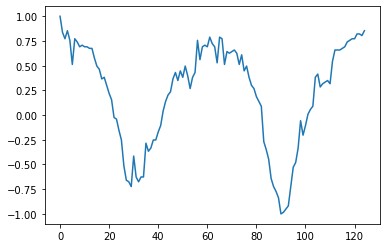

In [31]:
sns.lineplot(x, norm_data);

### RMS Calculation

The RMS value of a set of values (or a continuous-time waveform) is the square root of the arithmetic mean of the squares of the values, or the square of the function that defines the continuous waveform. In physics, the RMS current value can also be defined as the "value of the direct current that dissipates the same power in a resistor."

In the case of a set of n values $\{x_{1},x_{2},\dots ,x_{n}\}$, the RMS is:

$\displaystyle x_{\text{RMS}}={\sqrt {{\frac {1}{n}}\left(x_{1}^{2}+x_{2}^{2}+\cdots +x_{n}^{2}\right)}}.$

`NOTE that the RMS value is different for Normalized and Not Normalized data`

In [32]:
# Using regular python and not normalize data
rms = 0
for i in range(N):
    rms = rms + data[i]**2
rms = rms / N
rms = math.sqrt(rms)
print("rms = ", rms)

rms =  4.290552222723783


In [33]:
# Using regular python and normalize data
rms = 0
for i in range(N):
    rms = rms + norm_data[i]**2
rms = rms / N
rms = math.sqrt(rms)
print("rms = ", rms)

rms =  0.5659203688703145


In [34]:
# Using regular python and standartized data
for i in range(N):
    rms = rms + stand_data[i]**2
rms = rms / N
rms = math.sqrt(rms)
print("rms = ", rms)

rms =  3.9328087884307004


In [10]:
# Using numpy and not normalized data
rms = np.sqrt(np.mean(np.square(data)))
print("rms = ", rms)

rms =  4.290552222723784


In [11]:
# Using numpy and normalized data
rms = np.sqrt(np.mean(np.square(norm_data)))
print("rms = ", rms)

rms =  0.5659203688703143


In [35]:
# Using numpy and standartized data
rms = np.sqrt(np.mean(np.square(stand_data)))
print("rms = ", rms)

rms =  3.932808788430701


### Skewness and kurtosis calculation
https://towardsdatascience.com/skewness-kurtosis-simplified-1338e094fc85

In statistics, skewness and kurtosis are two ways to measure the **shape of a distribution**.

**Skewness** is a measure of the asymmetry of a distribution. This value can be positive or negative.
<img src="https://miro.medium.com/max/720/1*Gqd6Ioie0sa_Hryb3grsFQ.png" style="height:200px">
- A negative skew indicates that the tail is on the left side of the distribution, which extends towards more negative values.
- A positive skew indicates that the tail is on the right side of the distribution, which extends towards more positive values.
- A value of zero indicates that there is no skewness in the distribution at all, meaning the distribution is perfectly symmetrical.

**Kurtosis** is a measure of whether or not a distribution is heavy-tailed or light-tailed relative to a normal distribution.
<img src="https://miro.medium.com/max/720/1*cfWYbVWYm5oCQqYWEPX5Bw.png" style="height:400px">
- The kurtosis of a normal distribution is 3.
- If a given distribution has a kurtosis of less than 3, it is said to be playkurtic, which means it tends to produce fewer and less extreme outliers than the normal distribution.
- If a given distribution has a kurtosis greater than 3, it is said to be leptokurtic, which means it tends to produce more outliers than the normal distribution.

`NOTE that the Skewness and Kurtosis values is the same for Normalized and Not Normalized data`

Let's see the data distribution and the Skewness and kurtosis calculation

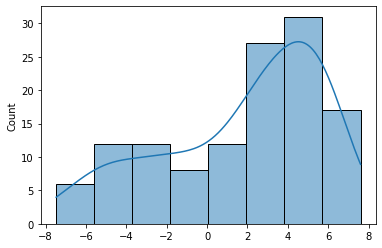

In [12]:
sns.histplot(data,kde=True);

In [13]:
print("skewness = ", skew(data, bias=False))
print("kurtosis = ", kurtosis(data, bias=False))

skewness =  -0.7359427285604101
kurtosis =  -0.6285390741135903


In [14]:
print("skewness = ", skew(norm_data, bias=False))
print("kurtosis = ", kurtosis(norm_data, bias=False))

skewness =  -0.7359427285604098
kurtosis =  -0.6285390741135912


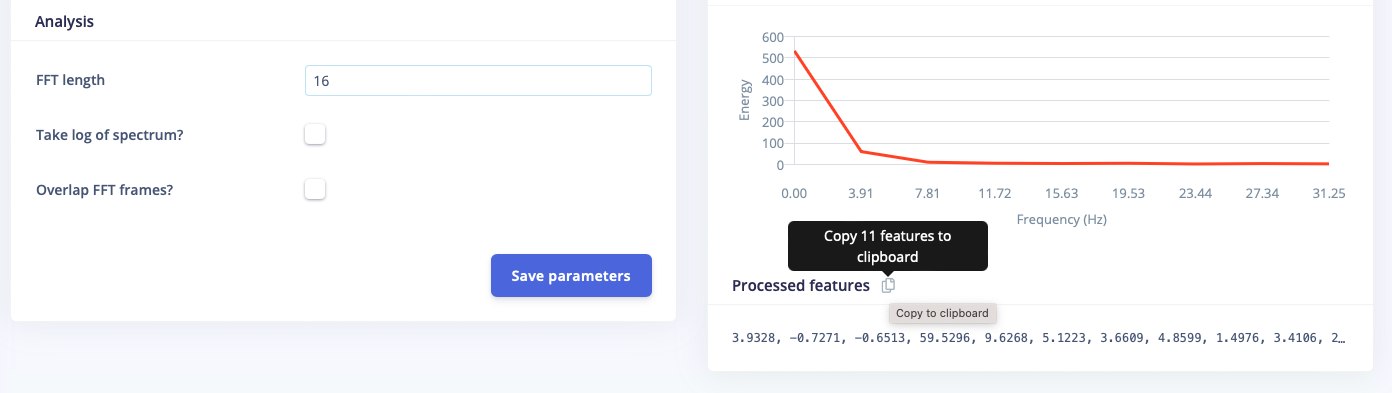

In the example, the processed features will be 11 (RMS, Skewness, Kurtosis and FFT Lenght / 2):
- RMS: 3.93
- Skiewness: -0.74
- Kurtosis: -0.63
- and 8 values calculed from the FFT process

## Spectral features

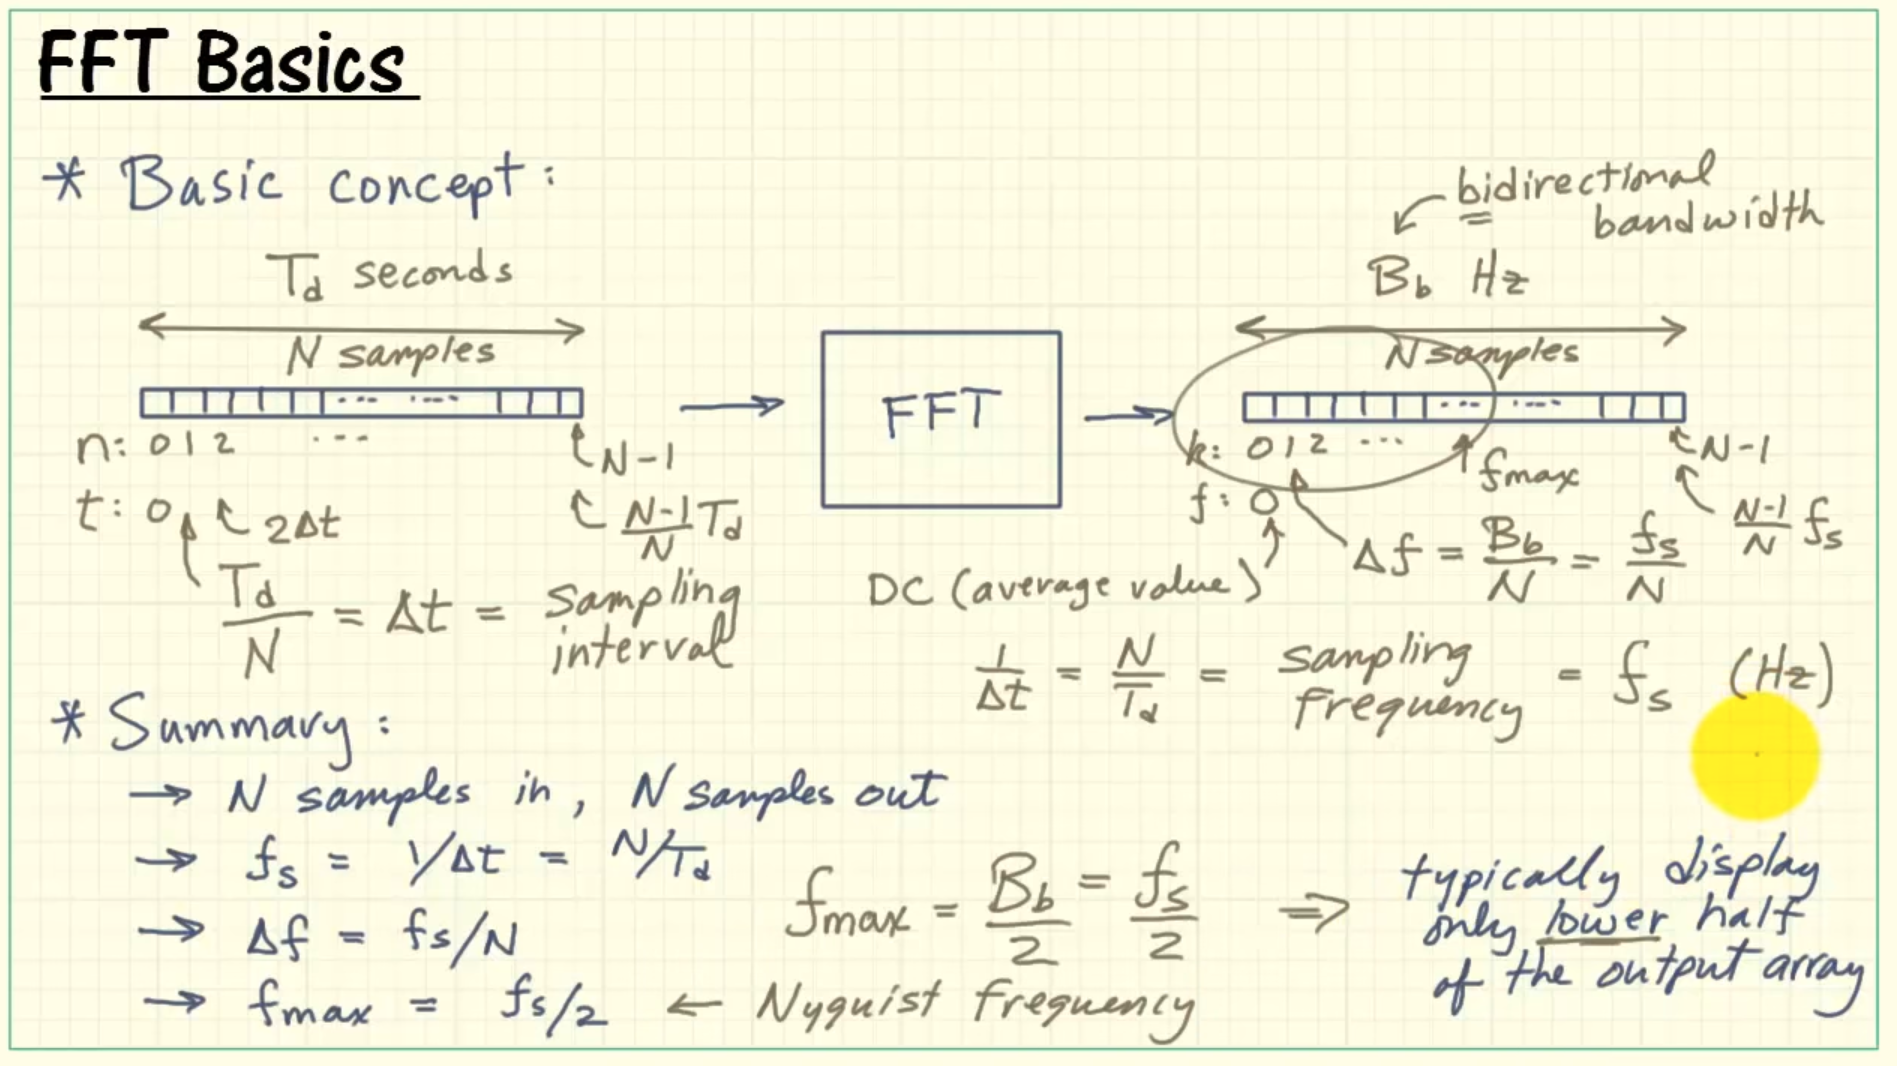

In [43]:
FFT_Lenght = 16 
N = 125
fs = 62.5

Once the sampled window usually is larger than the FFT size, the window will be broken into frames (or "sub-windows"), and the FFT is calculated from each frame.

**FFT length** - The FFT size. This determines the number of FFT bins as well as the resolution of frequency peaks that you can separate. A lower number means more signals will average together in the same FFT bin, but also reduces the number of features and model size. A higher number will separate more signals into separate bins, but generates a larger model.

Below are some examples of FFT calculation, but taken all tha data. 

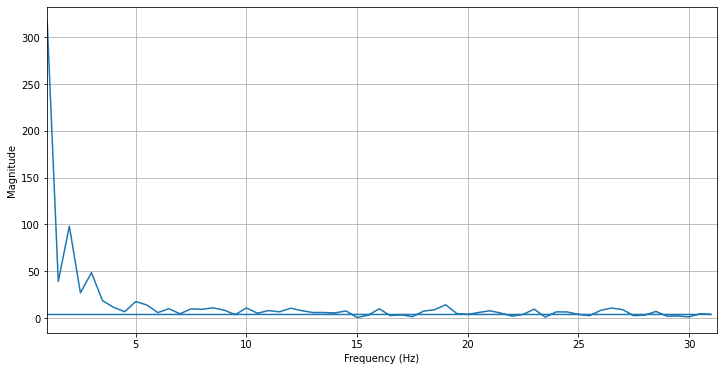

In [50]:
# Apply the FFT algorithm
fft_result = np.fft.fft(stand_data)

# Calculate the corresponding frequency axis
freq_axis = np.fft.fftfreq(len(stand_data), d=1/fs)

# Plot the FFT result
plt.figure(figsize = (12, 6))
plt.plot(freq_axis, np.abs(fft_result))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(1, fs/2)
plt.grid()
plt.show()

In [51]:
fft = np.abs(fft_result)
len(fft)

125

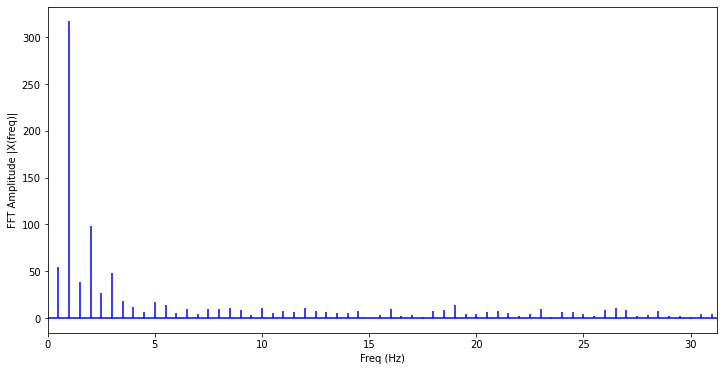

In [49]:
sr=fs
X = fft(stand_data)
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

plt.figure(figsize = (12, 6))

plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, sr/2);

### Estimate power spectral density using a periodogram.

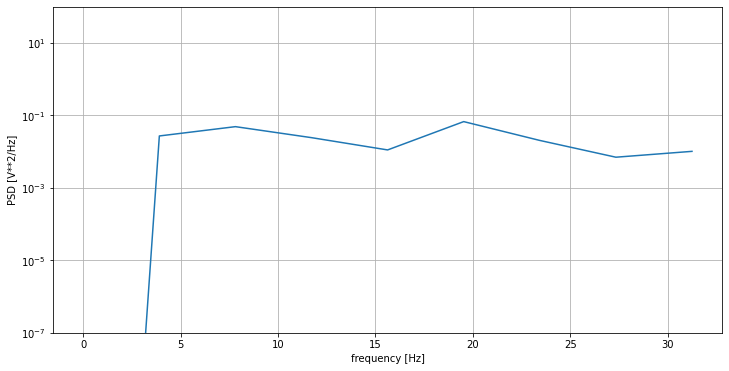

In [59]:
f, Pxx_den = signal.periodogram(stand_data, fs, nfft=FFT_Lenght)
plt.figure(figsize = (12, 6))
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.grid()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

Welch’s method computes an estimate of the power spectral density by dividing the data into overlapping segments, computing a modified periodogram for each segment and averaging the periodograms.

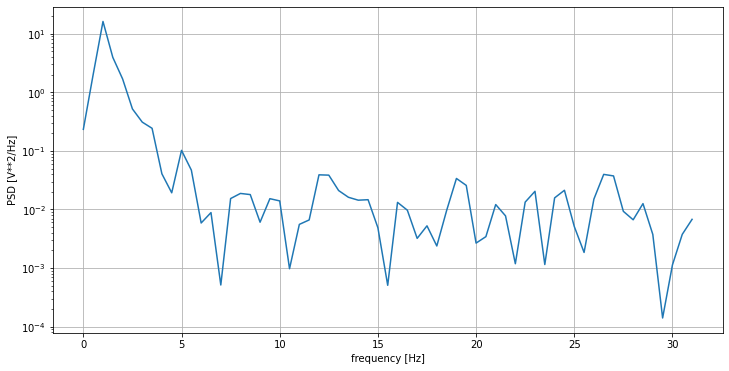

In [64]:
f, Pxx_den = signal.welch(stand_data, fs, nperseg=125)
plt.figure(figsize = (12, 6))
plt.semilogy(f, Pxx_den)
#plt.ylim([0.5e-3, 1])
plt.grid()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()